In [40]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
from sklearn.model_selection import StratifiedKFold , cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)


In [41]:
data = pd.read_csv('/Users/lakshyasoni/Documents/Diabetes_Predection_Project/data/train.csv')

In [42]:
data_train = data

In [43]:
data_train = pd.get_dummies(data_train , columns = ['gender','ethnicity','smoking_status','employment_status'], dtype = int)

In [44]:
edu_map = {'No formal' : 0 , 'Highschool': 1 ,'Graduate': 2 , 'Postgraduate' : 3}
inc_map = {'Low' : 0, 'Lower-Middle' : 1 ,'Middle' : 2 , 'Upper-Middle' : 3 ,'High' : 4}
data_train['education_level'] = data_train['education_level'].map(edu_map)
data_train['income_level'] = data_train['income_level'].map(inc_map)

In [45]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 37 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   id                                  700000 non-null  int64  
 1   age                                 700000 non-null  int64  
 2   alcohol_consumption_per_week        700000 non-null  int64  
 3   physical_activity_minutes_per_week  700000 non-null  int64  
 4   diet_score                          700000 non-null  float64
 5   sleep_hours_per_day                 700000 non-null  float64
 6   screen_time_hours_per_day           700000 non-null  float64
 7   bmi                                 700000 non-null  float64
 8   waist_to_hip_ratio                  700000 non-null  float64
 9   systolic_bp                         700000 non-null  int64  
 10  diastolic_bp                        700000 non-null  int64  
 11  heart_rate                

In [46]:
data_test=pd.read_csv('/Users/lakshyasoni/Documents/Diabetes_Predection_Project/data/test.csv')

In [47]:
data_test = pd.get_dummies(data_test , columns = ['gender','ethnicity','smoking_status','employment_status'], dtype = int)
data_test['education_level'] = data_test['education_level'].map(edu_map)
data_test['income_level'] = data_test['income_level'].map(inc_map)

In [48]:
X = data_train.drop(columns=['diagnosed_diabetes','id'])
y = data_train['diagnosed_diabetes'].astype(int)
X_test = data_test.drop(columns=['id'])
print(X.shape,y.shape,X_test.shape)
pos_rate = y.mean()
print("Positive class rate:", pos_rate)

# Cross-Validation with ROC-AUC

cv = StratifiedKFold(n_splits = 5 , shuffle = True , random_state = 42)

# Building the Pipeline

pipeline = Pipeline([('scaler' , StandardScaler()),
                   ('model' , LogisticRegression(max_iter = 1000, class_weight = 'balanced' if pos_rate < 0.2 else None , n_jobs = -1))])

auc_score = cross_val_score(
    pipeline,
    X,
    y,
    cv=cv,
    scoring='roc_auc',
    n_jobs = -1
)

print("ROC-AUC mean:", auc_score.mean())
print("ROC-AUC std :", auc_score.std())

(700000, 35) (700000,) (300000, 35)
Positive class rate: 0.6232957142857143
ROC-AUC mean: 0.6943500721064615
ROC-AUC std : 0.000817512783302189


In [49]:
# final model trained on Full training data
pipeline.fit(X,y)

,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


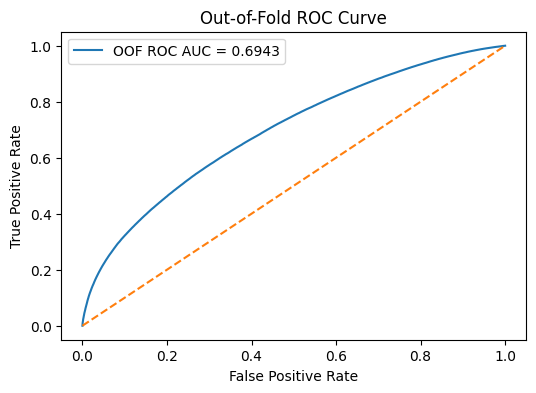

OOF ROC-AUC: 0.6943456829634894


In [50]:
# --------------------------
# Block B: Out-of-fold ROC (honest)
# --------------------------
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, auc

# get out-of-fold predicted probabilities (use same cv you used)
oof_proba = cross_val_predict(
    pipeline,
    X,
    y,
    cv=cv,
    method='predict_proba',
    n_jobs=-1
)[:, 1]

fpr, tpr, _ = roc_curve(y, oof_proba)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"OOF ROC AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Out-of-Fold ROC Curve')
plt.legend()
plt.show()

print("OOF ROC-AUC:", roc_auc)


In [51]:
# --------------------------
# Block C: Feature importance (logistic coefficients)
# --------------------------

model = pipeline.named_steps['model']       # LogisticRegression
coefs = model.coef_[0]                     # shape (n_features,)
feat_imp = pd.Series(coefs, index=X.columns).sort_values(key=abs, ascending=False)

# Show top 20 by absolute effect
topk = 20
print("Top features (by absolute coefficient):")
display(feat_imp.head(topk))

# Save to CSV for README / display
feat_imp.to_csv('feature_importance_coefficients.csv', header=['coef'])


Top features (by absolute coefficient):


family_history_diabetes               0.563906
physical_activity_minutes_per_week   -0.362675
age                                   0.312058
triglycerides                         0.106356
bmi                                   0.099434
diet_score                           -0.072431
hdl_cholesterol                      -0.061883
ldl_cholesterol                       0.053605
heart_rate                           -0.050845
screen_time_hours_per_day             0.040724
cholesterol_total                     0.027011
cardiovascular_history                0.022236
systolic_bp                           0.020791
diastolic_bp                         -0.017348
income_level                         -0.010615
ethnicity_Other                       0.010205
ethnicity_Hispanic                   -0.009813
employment_status_Retired            -0.008446
ethnicity_Asian                       0.006036
gender_Other                          0.005679
dtype: float64

In [52]:
# --------------------------
# Block D: Ensure alignment & predict on test
# --------------------------
# Reindex test to training features just in case
X_test = X_test.reindex(columns=X.columns, fill_value=0)

test_proba = pipeline.predict_proba(X_test)[:, 1]

# quick sanity check
print("min,max test proba:", test_proba.min(), test_proba.max())


min,max test proba: 0.01210797619471396 0.9817928890206065


In [53]:
# --------------------------
# Block F: Save model (joblib)
# --------------------------
import joblib

joblib.dump({
    'pipeline': pipeline,
    'features': list(X.columns)
}, 'diabetes_pipeline_v1.pkl')

print("Saved diabetes_pipeline_v1.pkl")


Saved diabetes_pipeline_v1.pkl


In [54]:
# =========================
# CONFIG & SETUP
# =========================
import json

TRAIN_CSV = "/Users/lakshyasoni/Documents/Diabetes_Predection_Project/data/train.csv"
MODEL_PKL = "diabetes_pipeline_v1.pkl"

OUT_DIR = "."  # Current directory (model/)
METRICS_JSON = os.path.join(OUT_DIR, "metrics_report.json")
ROC_PNG = os.path.join(OUT_DIR, "oof_roc_curve.png")

print("Config:")
print(f"  Train CSV: {TRAIN_CSV}")
print(f"  Model PKL: {MODEL_PKL}")
print(f"  Metrics Output: {METRICS_JSON}")
print(f"  ROC Plot: {ROC_PNG}")

Config:
  Train CSV: /Users/lakshyasoni/Documents/Diabetes_Predection_Project/data/train.csv
  Model PKL: diabetes_pipeline_v1.pkl
  Metrics Output: ./metrics_report.json
  ROC Plot: ./oof_roc_curve.png


In [55]:
# =========================
# LOAD MODEL & FEATURES
# =========================
saved = joblib.load(MODEL_PKL)
pipeline_eval = saved["pipeline"]
FEATURES_LIST = saved["features"]

print(f"Loaded pipeline with {len(FEATURES_LIST)} features")
print(f"Features: {FEATURES_LIST[:5]}... (showing first 5)")

Loaded pipeline with 35 features
Features: ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day']... (showing first 5)


In [58]:
# =========================
# LOAD & PREPROCESS DATA (for evaluation)
# =========================
df_eval = pd.read_csv(TRAIN_CSV)

# Ordinal mappings (MUST match training EXACTLY)
education_map = {
    "No formal": 0,
    "Highschool": 1,
    "Graduate": 2,
    "Postgraduate": 3
}

income_map = {
    "Low": 0,
    "Lower-Middle": 1,
    "Middle": 2,
    "Upper-Middle": 3,
    "High": 4
}

# Apply mappings
df_eval["education_level"] = df_eval["education_level"].map(education_map)
df_eval["income_level"] = df_eval["income_level"].map(income_map)

# Check for NaN after mapping and report
nan_edu = df_eval["education_level"].isna().sum()
nan_inc = df_eval["income_level"].isna().sum()
if nan_edu > 0 or nan_inc > 0:
    print(f"WARNING: Found {nan_edu} NaN in education_level, {nan_inc} NaN in income_level")
    print("Filling with mode (most common value)...")
    df_eval["education_level"].fillna(df_eval["education_level"].mode()[0], inplace=True)
    df_eval["income_level"].fillna(df_eval["income_level"].mode()[0], inplace=True)

# One-hot encode categoricals (same as training)
categorical_cols = ["gender", "ethnicity", "smoking_status", "employment_status"]
df_eval = pd.get_dummies(df_eval, columns=categorical_cols, dtype=int)

# Target
y_eval = df_eval["diagnosed_diabetes"].astype(int)

# Drop non-features
X_eval = df_eval.drop(columns=["diagnosed_diabetes", "id"], errors="ignore")

# Align columns EXACTLY to training features
for col in FEATURES_LIST:
    if col not in X_eval.columns:
        X_eval[col] = 0

X_eval = X_eval[FEATURES_LIST]

# Final NaN check and fill
if X_eval.isna().sum().sum() > 0:
    print(f"WARNING: Found {X_eval.isna().sum().sum()} total NaN values in X_eval")
    print("Filling NaN with 0...")
    X_eval.fillna(0, inplace=True)

print(f"Data shape: X={X_eval.shape}, y={y_eval.shape}")
print(f"Positive rate: {y_eval.mean():.4f}")
print(f"NaN count in X_eval: {X_eval.isna().sum().sum()}")

Data shape: X=(700000, 35), y=(700000,)
Positive rate: 0.6233
NaN count in X_eval: 0


In [59]:
# =========================
# OUT-OF-FOLD PREDICTIONS & METRICS
# =========================
cv_eval = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_proba = cross_val_predict(
    pipeline_eval,
    X_eval,
    y_eval,
    cv=cv_eval,
    method="predict_proba",
    n_jobs=-1
)[:, 1]

# Default classification threshold (0.5)
oof_pred = (oof_proba >= 0.5).astype(int)

# Calculate all metrics
metrics = {
    "roc_auc_oof": float(roc_auc_score(y_eval, oof_proba)),
    "accuracy_oof": float(accuracy_score(y_eval, oof_pred)),
    "precision_oof": float(precision_score(y_eval, oof_pred, zero_division=0)),
    "recall_oof": float(recall_score(y_eval, oof_pred, zero_division=0)),
    "f1_oof": float(f1_score(y_eval, oof_pred, zero_division=0)),
    "confusion_matrix": confusion_matrix(y_eval, oof_pred).tolist(),
    "classification_report": classification_report(
        y_eval,
        oof_pred,
        zero_division=0,
        output_dict=True
    )
}

print("Metrics computed successfully!")
print(f"  ROC-AUC: {metrics['roc_auc_oof']:.4f}")
print(f"  Accuracy: {metrics['accuracy_oof']:.4f}")

Metrics computed successfully!
  ROC-AUC: 0.6943
  Accuracy: 0.6633


In [61]:
# =========================
# SAVE METRICS TO JSON
# =========================
os.makedirs(OUT_DIR, exist_ok=True)

with open(METRICS_JSON, "w") as f:
    json.dump(metrics, f, indent=2)

print(f"\n✓ Metrics saved to: {METRICS_JSON}")


✓ Metrics saved to: ./metrics_report.json


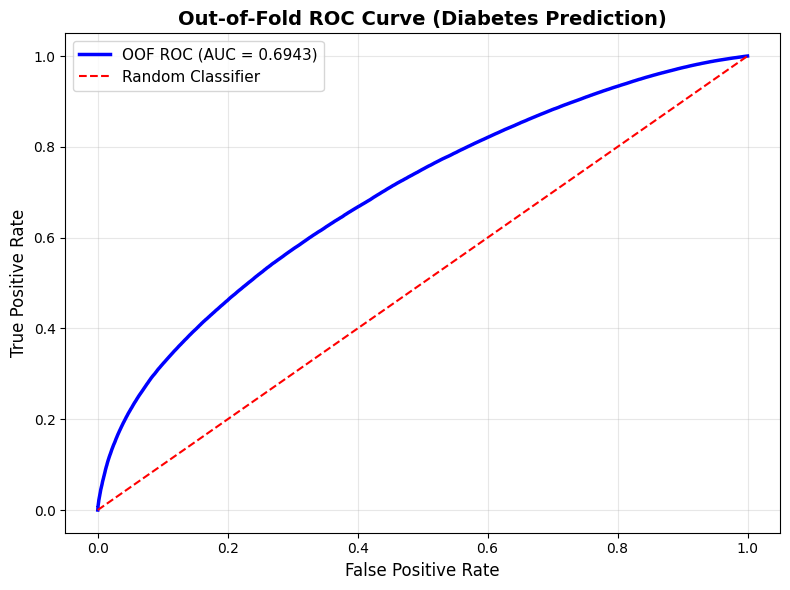

✓ ROC curve saved to: ./oof_roc_curve.png


In [62]:
# =========================
# GENERATE & SAVE ROC CURVE
# =========================
fpr, tpr, _ = roc_curve(y_eval, oof_proba)
roc_auc_val = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', linewidth=2.5, label=f"OOF ROC (AUC = {roc_auc_val:.4f})")
plt.plot([0, 1], [0, 1], color='red', linestyle="--", linewidth=1.5, label="Random Classifier")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("Out-of-Fold ROC Curve (Diabetes Prediction)", fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(ROC_PNG, dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ ROC curve saved to: {ROC_PNG}")

In [63]:
# =========================
# PRINT EVALUATION SUMMARY
# =========================
print("\n" + "="*50)
print("  MODEL EVALUATION SUMMARY (Out-of-Fold)")
print("="*50)
print(f"\nROC-AUC       : {metrics['roc_auc_oof']:.4f}")
print(f"Accuracy      : {metrics['accuracy_oof']:.4f}")
print(f"Precision     : {metrics['precision_oof']:.4f}")
print(f"Recall        : {metrics['recall_oof']:.4f}")
print(f"F1 Score      : {metrics['f1_oof']:.4f}")

print("\nConfusion Matrix:")
cm = metrics["confusion_matrix"]
print(f"  [[TN={cm[0][0]}, FP={cm[0][1]}],")
print(f"   [FN={cm[1][0]}, TP={cm[1][1]}]]")

print("\nClassification Report:")
print(json.dumps(metrics["classification_report"], indent=2))

print("\n" + "="*50)
print("Files Saved:")
print("="*50)
print(f"✓ Metrics JSON : {METRICS_JSON}")
print(f"✓ ROC Curve    : {ROC_PNG}")
print("="*50 + "\n")


  MODEL EVALUATION SUMMARY (Out-of-Fold)

ROC-AUC       : 0.6943
Accuracy      : 0.6633
Precision     : 0.6813
Recall        : 0.8640
F1 Score      : 0.7618

Confusion Matrix:
  [[TN=87329, FP=176364],
   [FN=59330, TP=376977]]

Classification Report:
{
  "0": {
    "precision": 0.5954561261156833,
    "recall": 0.33117678512512655,
    "f1-score": 0.42562970327913596,
    "support": 263693.0
  },
  "1": {
    "precision": 0.6812742955971092,
    "recall": 0.8640177673060483,
    "f1-score": 0.7618405736180945,
    "support": 436307.0
  },
  "accuracy": 0.6632942857142857,
  "macro avg": {
    "precision": 0.6383652108563962,
    "recall": 0.5975972762155874,
    "f1-score": 0.5937351384486153,
    "support": 700000.0
  },
  "weighted avg": {
    "precision": 0.6489462233613011,
    "recall": 0.6632942857142857,
    "f1-score": 0.6351884978576788,
    "support": 700000.0
  }
}

Files Saved:
✓ Metrics JSON : ./metrics_report.json
✓ ROC Curve    : ./oof_roc_curve.png

